### Design the State Variables 6

For our robot we will maintain the position and orientation:

$$\mathbf x = \begin{bmatrix}x & \dot x & y & \dot y & \theta & \dot \theta\end{bmatrix}^\mathsf{T}$$


The control input $\mathbf{u}$ is the commanded linear velocity and the commanded angular velocity 

$$\mathbf{u} = \begin{bmatrix} \dot x & \dot y & w\end{bmatrix}^\mathsf{T}$$

In [4]:
from math import sin, cos
import numpy as np
from threading import Timer

class InputOutputLinearization:
    def __init__(self, robot, estimator, **kwargs):
        self.robot = robot
        self.estimator = estimator
        self.timer = None
        self.trajectory_timers = []
        self.desired_position = None
        self._desired_speed = None
        self.goal_reached = False
        self.current_point_index = 0
        self.trajectory_points = None
        self.dt = 0
        
        self.f_s = kwargs.get('f_s', 100)
        self.b = kwargs.get('b', 0.05)
        self.k1 = kwargs.get('k1', 1)
        self.k2 = kwargs.get('k2', 1)
        self.epsilon = kwargs.get('epsilon', 0.025)        
        
    def compute_control_input(self, state, des_position, des_speed):
        x, y, theta = state
        y1 = x + self.b * cos(theta)
        y2 = y + self.b * sin(theta)
        y1_d, y2_d = des_position
        y1_dot_d, y2_dot_d = des_speed

        u1 = y1_dot_d + self.k1 * (y1_d - y1)
        u2 = y2_dot_d + self.k2 * (y2_d - y2)

        T = np.array([[np.cos(theta), -self.b*np.sin(theta)],
                      [np.sin(theta), self.b*np.cos(theta)]])
        T_inv = np.linalg.inv(T)
        v, omega = np.dot(T_inv, np.array([u1, u2]))
        
        return v, omega / 2
    
    def compute_desired_speed(self):
        dx = self.desired_position[0] - self.estimator.position[0]
        dy = self.desired_position[1] - self.estimator.position[1]
        theta = np.arctan2(dy, dx)
        speed = [self.robot.max_vel * cos(theta), self.robot.max_vel * sin(theta)]
        return speed
        
    def execute_trajectory(self, trajectory_points, dt=1):
        self.trajectory_timers = []
        for index, point in enumerate(trajectory_points):
            timer = Timer(dt * index, self.go, args=[point])
            self.trajectory_timers.append(timer)
            timer.start()

In [5]:
from scipy.linalg import inv,block_diag
from filterpy.common import Q_discrete_white_noise
from math import tan, sin, cos
from numpy.random import randn
import numpy as np
import matplotlib.pyplot as plt
from filterpy.stats import plot_covariance


class KF_DD:
    def __init__(self,x = np.array([0.,0.,0.,0.,0.,0.]),P=np.diag([.01,.01,.01,.01,.01,.01]),R_var=0.01,Q_var=0.01,dt=0.01):
        self.x = x.T
        self.P = P
        self.F = np.array([[1, dt, 0, 0, 0, 0],
                            [0, 0, 0, 0, 0, 0],
                            [0, 0, 1, dt, 0, 0],
                            [0, 0, 0, 0, 0, 0],
                            [0, 0, 0, 0, 1, dt],
                            [0, 0, 0, 0, 0, 0]])
        self.B = np.array([[0, 0 ,0],
                            [1, 0 ,0],
                            [0, 0 ,0],
                            [0, 1 ,0],
                            [0, 0 ,0],
                            [0, 0 ,1]])
        self.H = self.B.T
        self.R= np.diag([R_var,R_var,R_var])
        self.Q = block_diag(Q_discrete_white_noise(2, dt=dt, var=Q_var), 
                            Q_discrete_white_noise(2, dt=dt, var=Q_var), 
                            Q_discrete_white_noise(2, dt=dt, var=Q_var))
        self.dt = 0
        self.K=[]
          
        
    def predict(self, u):
        self.x = self.F @ self.x + self.B @ u
        self.P = self.F @ self.P @ self.F.T + self.Q
    
    def update(self, z):
        S = self.H @ self.P @ self.H.T + self.R
        self.K = self.P @ self.H.T @ inv(S)
        y = z - self.H @ self.x
        self.x += self.K @ y
        self.P = self.P - self.K @ self.H @ self.P

def kinematic_model(state, control, dt):
    x, y, theta = state
    v, omega = control

    # Derivate del sistema
    dx = v * cos(theta)
    dy = v * sin(theta)
    dtheta = omega

    return np.array([dx, dy, dtheta])

def runge_kutta(state, control, dt):
    k1 = kinematic_model(state, control, dt)
    k2 = kinematic_model(state + 0.5 * dt * k1, control, dt)
    k3 = kinematic_model(state + 0.5 * dt * k2, control, dt)
    k4 = kinematic_model(state + dt * k3, control, dt)

    new_state = state + (dt / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)
    return new_state

def move_real(x, dt, u,v_std,w_std):
    v_act = u[0] + randn()*v_std
    w_act = u[1] + randn()*w_std
    theta = x[4]
    x[5]=w
    x[1]=v * cos(theta)
    x[3]=v * sin(theta) 
    
    x[0],x[2],x[4]=runge_kutta((x[0],x[2],x[4]),[v_act,w_act],dt)

    return x 


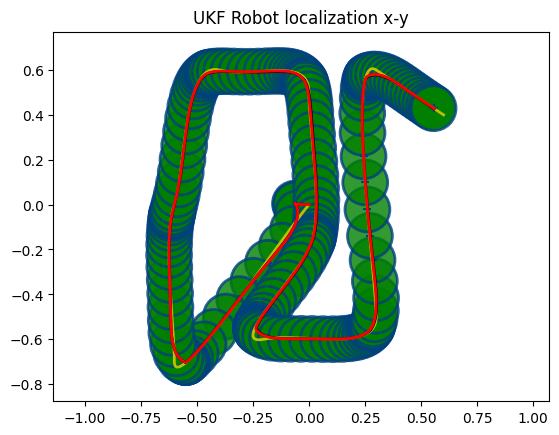

In [6]:
from trajectory_planning.trajectory_planner import *

fs=100
dt=1/fs

path = [(0,0),(-.6, -.7), (-.6, 0), (-.4, .6), (0, .5), (0, -.2), (-.2, -.6), (.3, -.5), (.3, .6), (.6, .4)]
TP = TrajectoryPlanner(np.zeros((100, 100)), path_list=path)
x_des, y_des, x_dot_des, y_dot_des, theta_des, theta_dot_des = TP.cartesian_traj(f_s=fs, profile=CUBIC_POL_PROF)

KF=KF_DD(dt=dt)
controller=InputOutputLinearization(0,runge_kutta)
sim_pos=KF.x
xs, cov = [], []
track=[]
plt.figure()

for i in range(len(x_des)):
    
    #real system
    for i in range(10): 
        sim_pos=move_real(sim_pos, dt/10, u=[v,w], v_std=.01, w_std=.01)
        track.append(list(sim_pos))  

    v,w=controller.compute_control_input([KF.x[0],KF.x[2],KF.x[4]], [x_des[i],y_des[i]], [x_dot_des[i],y_dot_des[i]])
    u=[v*cos(KF.x[4]),v*sin(KF.x[4]),w]

    #prediction step
    KF.predict(u)
    
    if i%100==0:
        cova =np.diag([KF.P[0,0],KF.P[2,2]])
        cova[0,1]=KF.P[0,2]
        cova[1,0]=KF.P[2,0]
        plot_covariance((KF.x[0], KF.x[2]), cov=cova,facecolor='g', alpha=0.8) 

    #mesurement
    z=np.array([sim_pos[1],sim_pos[3],sim_pos[5]])
    
    #update step
    KF.update(z)
    
    if i%10==0:
        cova =np.diag([KF.P[0,0],KF.P[2,2]])
        cova[0,1]=KF.P[0,2]
        cova[1,0]=KF.P[2,0]
        plot_covariance((KF.x[0], KF.x[2]), cov=cova,facecolor='g', alpha=0.8) 
    
    xs.append(KF.x)
    cov.append(KF.P)
 
xs, cov = np.array(xs), np.array(cov)
track = np.array(track)

#plot
plt.plot(x_des, y_des, color='y', lw=2)
plt.plot(track[:, 0], track[:,2], color='k', lw=2)
plt.plot(xs[:, 0], xs[:,2], color='r', lw=2)
plt.axis('equal')
plt.title("UKF Robot localization x-y")
plt.show()